# The Battle of Neighbourhoods 

# 1. Introduction/Business Problem

- Working class people are always moving from one place to another either to find better jobs or to change their lifestyles a little bit. 
- My cousin got a job offer from a great company with mindblowing employees benefits and perks but in other country. 
- He took the job offer because it was a once on a lifetime opportunity and now he and his family need to change to a whole new location. From New York to Toronto. 
- They are urgently in need of someplace exactly or strictly similiar to their last location because they have been living there for many years so they love their current neighbourhood venue settings and amenities. 
- Eitherway they always get to the same general obstacles for anyone trying to please every family member while scouting for new places to live. 
- The essential most important ones are like: the company location or site, schools nearby, health centers, grocery shops, entertainment, recreational parks, restaurants, coffe shops, etc..

How are they going to find another city, borough or neighbourhoods with all those conditions for everyone to be happy as they are right now???  

We'll find out what makes borough-neighbourhoods similar to define a new location. Moving somewhere can be within the city or from one city to another. If moving within the same city then we'll find neighbourhoods in that borough which are very similar to their last location. If moving it's being done from one city to another city then my task would be finding the similar neighbourhoods.

# 2. Data

In [3]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
!pip install matplotlib-venn
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib_venn import venn2

!pip install bs4
!pip3 install beautifulsoup4
from urllib.request import urlopen
from bs4 import BeautifulSoup

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported.')

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Libraries imported.


In [4]:
!conda install --yes lxml

Solving environment: ...working... done

# All requested packages already installed.



## 2.1 Reading Data

## 2.1.2 Gathering New York Data

My first city would be New York city, here's the [link](https://cocl.us/new_york_dataset) to access the data. NY data is in a json format and it's easily transformed into pandas dataframe. We'll be using the borough and neighbourhood data of two cities. We´ll only keep the important ones like borough, neighbourhood, latitude and longitude. For more information of this data you can visit this [NYU webpage](https://geo.nyu.edu/catalog/nyu_2451_34572). 

In [17]:
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('Data downloaded!') 

Data downloaded!


In [18]:
with open('newyork_data.json') as f:
    NY_json = json.load(f)

# relevant information is in 'features' key
NY_json = NY_json['features']
NY_json[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

In [19]:
#let's make empty dataframe and put the useful information of json data into dataframe
cols = ['Borough', 'Neighbourhood', 'Latitude', 'Longitude']
NY_df = pd.DataFrame(columns = cols)
for data in NY_json:
    borough = data['properties']['borough']
    neigh = data['properties']['name']
    lat_lon = data['geometry']['coordinates'] # now it'll return list
    lon, lat = lat_lon[0], lat_lon[1]
    
    NY_df = NY_df.append({'Borough': borough,'Neighbourhood': neigh, 'Latitude': lat,
                          'Longitude': lon}, ignore_index=True)
    
NY_df.head()

,Borough,Neighbourhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


## 2.1.2 Gathering Toronto Data¶

Second city would be Toronto city. It can´t be directly downloaded. Postal Code, borough and neighbourhood can be scrapped from the [Wikipedia page](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M). Latitude and longitude information can be downloaded from the 'geocode.csv'. Used csv file download the csv and read it into pd. There are some rows where “Not assigned” is written. Drop the rows where borough is “Not assigned” (only).  

If Neighbouthood is 'Not assigned' but Borough is assigned then make corresponding Borough as Neighbourhood. Merge the rows if Postal Code and Borough of two or more rows same and merged neighbourhood will be separated by comma “,”. Latitude and longitude info taken from [here](https://cocl.us/Geospatial_data). Finally this data and Toronto data can be merged together. Once both data are ready we’ll use Foursquare API to get the venues near each neighbourhood.

In [20]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
source = requests.get(url).text
soup = BeautifulSoup(source)

table_data = soup.find('div', class_='mw-parser-output')
table = table_data.table.tbody

columns = ['Postal Code', 'Borough', 'Neighbourhood']
data = dict({key:[]*len(columns) for key in columns})

for row in table.find_all('tr'):
    for i,column in zip(row.find_all('td'),columns):
        i = i.text
        i = i.replace('\n', '')
        data[column].append(i)
        
toronto_df = pd.DataFrame.from_dict(data=data)[columns]
print("Before dropping the 'Not assigned' rows, shape is: ",toronto_df.shape)

toronto_df = toronto_df[toronto_df['Borough'] != 'Not assigned'].reset_index(drop = True)
print('After dropping rows where borough is "Not assigned", Shape is: ',toronto_df.shape)
print('Number of rows where Neighbourhood is "Not assigned" but borough has value: ', 
      toronto_df[toronto_df['Neighbourhood'] == 'Not assigned'].shape[0])

# making corresponding Borough as Neighbourhood: where Neighbourhood is 'Not assigend'
p, b, n = [], [], []
for postcode, borough, neigh in zip(toronto_df['Postal Code'], toronto_df['Borough'], toronto_df['Neighbourhood']):
    p.append(postcode)
    b.append(borough)
    if neigh == 'Not assigned':
        n.append(borough)
    else:
        n.append(neigh)

toronto_df = pd.DataFrame({'Postal Code': p, 'Borough': b, 'Neighbourhood':n})[columns]

#merging the rows, where Postal Code and Borough is same and Neighbourhoods will be seperated by ','
# :https://stackoverflow.com/a/27298308
toronto_df = toronto_df.groupby(['Postal Code', 'Borough'])['Neighbourhood'].apply(', '.join).reset_index()
print('Before Adding the latitude and longitue, shape is: ',toronto_df.shape)

latlon = pd.read_csv('geocode.csv')
#mergign the latitude and longitude
print("\nColumns of latlon are: {},\nSo merging on '{}'".format(latlon.columns, latlon.columns[0]))
toronto_df = pd.merge(toronto_df, latlon, how= 'inner', on = 'Postal Code')
print('Final Shape of data is: ', toronto_df.shape)

Before dropping the 'Not assigned' rows, shape is:  (180, 3)
After dropping rows where borough is "Not assigned", Shape is:  (103, 3)
Number of rows where Neighbourhood is "Not assigned" but borough has value:  0
Before Adding the latitude and longitue, shape is:  (103, 3)

Columns of latlon are: Index(['Postal Code', 'Latitude', 'Longitude'], dtype='object'),
So merging on 'Postal Code'
Final Shape of data is:  (103, 5)


In [21]:
toronto_df.head(10)

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.727929,-79.262029
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


## 2.2 Getting Venues Using Foursquare API

In [22]:
CLIENT_ID = 'JZPSHB3FTUKUWT15U2X0YXJQZXCCYZFH1Z0QHZAOPL0GF10O' # your Foursquare ID
CLIENT_SECRET = '2WBVHEK3YYVMANARI0Z1KI01Q45OD305OXMINXMVOUUKROQU' # your Foursquare Secret
VERSION = '20200611' # Foursquare API version
LIMIT = 100

In [23]:
def get_near_by_venues(names, latitudes, longitudes, radius= 1000):    
    venues_list = []
    
    for name, lat, lng in zip(names, latitudes, longitudes):

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'\
        .format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)    

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(name, lat, lng, 
                             v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'],
                             v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue in venues_list for item in venue])
    nearby_venues.columns = ['Neighbourhood','Neighbourhood Latitude', 'Neighbourhood Longitude', 
                             'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    
    return nearby_venues

In [24]:
def explore_borough(df, borough):
    new_df = df[df['Borough'] == borough].reset_index(drop = True)
    venues =  get_near_by_venues(names = new_df['Neighbourhood'],latitudes = new_df['Latitude'],
                                 longitudes = new_df['Longitude'])

    onehot_df = pd.get_dummies(venues[['Venue Category']], prefix= "", prefix_sep= "")

    # # add neighborhood column back to dataframe
    onehot_df['Neighbourhood'] = venues['Neighbourhood']
    # move neighborhood column to the first column
    fixed_columns = [onehot_df.columns[-1]] + list(onehot_df.columns[:-1])
    onehot_df = onehot_df[fixed_columns]
    onehot_df_grouped = onehot_df.groupby('Neighbourhood').mean().reset_index()
    
    onehot_coded_df = pd.merge(new_df, onehot_df_grouped, on = 'Neighbourhood', how = 'left')
    
    return onehot_coded_df

In [25]:
def return_venues_for_boroughs(df):
    col = list(df.columns)
    all_venues = pd.DataFrame()
    for i in df['Borough'].unique():
        new_df = df[df['Borough'] == i]
        print('For borough: ',i)
        a = explore_borough(new_df, i)
        all_venues = pd.concat([a, all_venues], axis = 0, ignore_index = True, sort = True)
    cols = col + [j for j in all_venues.columns if j not in col]
    all_venues = all_venues[cols]
    return all_venues

## 2.2.1 For New York City

In [26]:
try:
    df1 = pd.read_csv('New_York_venue.csv')
except:
    df1 = return_venues_for_boroughs(NY_df)
    df1.fillna(0,  inplace = True)
    df1.to_csv('New_York_venue.csv',  index_label = False)
print('Shape data is: ', df1.shape)
df1.head() 

Shape data is:  (306, 475)


,Borough,Neighbourhood,Latitude,Longitude,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Baggage Locker,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Car Wash,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Gym,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cruise Ship,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Rink,Home Service,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Kofte Place,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Lebanese Restaurant,Library,Lighthouse,Lingerie Store,Liquor Store,Locksmith,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Middle School,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,M

## 2.2.2 For Toronto City

In [27]:
try:
    df2 = pd.read_csv('Toronto_venue.csv')
except:
    df2 = return_venues_for_boroughs(toronto_df)
    df2.fillna(0, inplace = True)
    df2.to_csv('Toronto_venue.csv',  index_label = False)
print('Shape data is: ', df2.shape)
df2.head()

Shape data is:  (103, 339)


,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Quad,College Rec Center,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fireworks Store,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundry Service,Light Rail Station,Lighting Store,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Photography Lab,Pide Place,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Ri

* Now our data is ready to process. We've 475 columns in New York data and 339 columns in Toronto city data.
* Other than these columns ('Borough', 'Neighbourhood', 'Latitude', 'Longitude') of New York city data are nearby venues of corresponding Neighbourhood.
- Other than these columns ('Postal Code', 'Borough', 'Neighbourhood', 'Latitude', 'Longitude',) of Toronto city data are nearby venues of corresponding Neighbourhood.

# 3. Exporatory Data Analysis (EDA)

- Both dataset has different number of columns, but many of them are common.
- Let's find how many of them are common.  

**Note:** 'Borough', 'Neighbourhood', and 'Latitude' columns of New York data and 'Postal Code', 'Borough', 'Neighbourhood', and 'Latitude' of Toronto city data will not be counted, when we'll be finding the common columns of both data.  

**Common Venue categories**  

* Let's find out how many venue categories are common in both cities data.
* We'll deal with only common vanue categories data amd rest other venue categories will be dropped.

In [28]:
print('Leaving {} columns of New York city data\nLeaving {} columns of Toronto city data'
      .format(list(df1.columns[0:4]), list(df2.columns[0:5])))
common = 0
diff_in_NY = 0

for i in df1.columns[4:]:
    if i in df2.columns[5:]:
        common += 1
    else:
        diff_in_NY += 1

print('\nNumber of common venue categories in both data are : {}\n\
Number of different venue categories in New York city are: {}\n\
Number of different venue catehories in Toronto city are : {}'.format(common, diff_in_NY,
                                                                     len(df2.columns[5:])-common))

Leaving ['Borough', 'Neighbourhood', 'Latitude', 'Longitude'] columns of New York city data
Leaving ['Postal Code', 'Borough', 'Neighbourhood', 'Latitude', 'Longitude'] columns of Toronto city data

Number of common venue categories in both data are : 300
Number of different venue categories in New York city are: 171
Number of different venue catehories in Toronto city are : 34


- Let's visualize them using **Venn diagram**

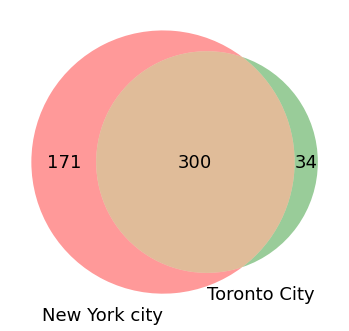

In [29]:
cl1 = set(df1.columns[4:])
cl2 = set(df2.columns[5:])
plt.figure(figsize = (6,6))
out = venn2([set(cl1), set(cl2)], set_labels = ['New York city', 'Toronto City'])
# chnage the text size of matplotlib venn:https://stackoverflow.com/a/29426251
for text in out.set_labels:
    text.set_fontsize(18)
for text in out.subset_labels:
    text.set_fontsize(18)
plt.show()

* Let's get common venue categories of both data and drop the rest other categories.

In [30]:
comm_col = []
for i in df1.columns[4:]:
    if i in df2.columns[5:]:
        comm_col.append(i)

col1 = list(df1.columns[0:4]) + comm_col
col2 = list(df2.columns[0:5]) + comm_col
print('Before reomoving non-common shape of New York: {}, and shape of Toronto is: {}'
      .format(df1.shape, df2.shape))
df1 = df1.loc[:, col1]
df2 = df2.loc[:, col2]
print('After reomoving non-common shape of New York: {}, and shape of Toronto is: {}'
      .format(df1.shape, df2.shape))

Before reomoving non-common shape of New York: (306, 475), and shape of Toronto is: (103, 339)
After reomoving non-common shape of New York: (306, 304), and shape of Toronto is: (103, 305)


# 4. Find Most Similar Location in other City (New York - Toronto)

* To find the most similar city, cosine similarity will be used.
* This kind of recommendation comes under item-item based recommender system.  

So my cousin who is living in the Bronx, Riverdale, New York city. Now he needs to move to Toronto city where his new job will be taking place. The family wants to find the most similar neighbourhood to their current location but in Toronto city.

* We'll be finding only top 7 most similar boroughs.
* Find following details of his/her location from above data:
  * index value
  * latitude
  * longitude 
  * venues near this location

In [31]:
def return_ordered_num(n_most_similar):
    a = ['st', 'nd', 'rd']
    c = []
    for i in range(1,20+1):
        if i == 1:
            c.append(str(i)+str(a[i-1]))
        elif i == 2:
            c.append(str(i)+str(a[i-1]))
        elif i == 3:
            c.append(str(i)+str(a[i-1]))
        else:
            c.append(str(i)+'th')
    return c

In [32]:
index = df1.loc[(df1['Borough'] == 'Bronx')
                & (df1['Neighbourhood'] == 'Riverdale')].index.values.astype(int)[0]
lat = df1.loc[index]['Latitude']
lon = df1.loc[index]['Longitude']
print('Index : {}\nLatitude : {}\nLongitude: {}'.format(index, lat, lon))

Index : 258
Latitude : 40.890834493891305
Longitude: -73.9125854610857


In [33]:
ny_data = df1.loc[:,comm_col] # selecting only common venues
toronto_data = df2.loc[:,comm_col] # selecting only common venues

# converting into numpy ndarray
X1 = ny_data.values
X2 = toronto_data.values
print('Shape of X1: {}\nShape of X2: {}'.format(X1.shape, X2.shape))

Shape of X1: (306, 300)
Shape of X2: (103, 300)


- Let's find most similar boroughs by using cosine similarity.

In [34]:
a = np.matmul(X1[index], X2.T)
#return the index in sorted order (descending)of values, 
#first element correspond to the index of maximum value in a
aa = np.argsort(-a)[0:7] 
my_borough = df2.iloc[aa, :]
print(my_borough.shape)
my_borough.head()

(7, 305)


,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Bike Shop,Bistro,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundry Service,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Steakhouse,Storage Facility,Street Art,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restauran

- Let's visualize similar boroughs using **Folium.**

In [35]:
c = return_ordered_num(7)

current_location_popup = 'Bronx, Riverdale, New York'
label = folium.Popup(current_location_popup)

my_map = folium.Map(location = [lat, lon], zoom_start = 6)
folium.CircleMarker([lat, lon], popup = label, fill_color = '#3186cc', fill_opacity = 1)

# add markers to map
for lat, lng, label, priority in zip(my_borough['Latitude'], my_borough['Longitude'], 
                                     my_borough['Neighbourhood'], c):
    label = folium.Popup(label)
    folium.Marker([lat, lng], popup = label).add_to(my_map)
    
my_map

# 5. Function for all steps of 4

* This function can be used for both cities. We can find most similar borough in either cities.

In [36]:
def most_similar_borough(current_city, current_borough, current_neigh, n_most_similar):
    ny_data = df1.iloc[:,4:]
    toronto_data = df2.iloc[:,5:]
    if current_city.lower() == 'New York'.lower():
        X1 = ny_data.values
        X2 = toronto_data.values
        index = df1.loc[(df1['Borough'] == current_borough)
                        & (df1['Neighbourhood'] == current_neigh)].index.values.astype(int)[0]
        lat = df1.loc[index]['Latitude']
        lon = df1.loc[index]['Longitude']
    else:
        X1 = toronto_data.values
        X2 = ny_data.values
        index = df2.loc[(df2['Borough'] == current_borough)
                        & (df2['Neighbourhood'] == current_neigh)].index.values.astype(int)[0]
        lat = df2.loc[index]['Latitude']
        lon = df2.loc[index]['Longitude']
    
    a = np.matmul(X1[index], X2.T)
    aa = np.argsort(-a)[0:n_most_similar]
    
    if current_city.lower() == 'New York'.lower():
        my_borough = df2.iloc[aa, :]
    else:
        my_borough = df1.iloc[aa, :]
   
    # for tooltip of map
    c = return_ordered_num(n_most_similar)
    
    current_location_popup = '{}, {}, {}'.format(current_neigh, current_borough, current_city)
    label = folium.Popup(current_location_popup)
    
    my_map = folium.Map(location = [lat, lon], zoom_start = 6)
    folium.CircleMarker([lat, lon], popup = label, fill_color = '#3186cc', fill_opacity = 1, fill = True).add_to(my_map)

    # add markers to map
    for lat, lng, label, priority in zip(my_borough['Latitude'], my_borough['Longitude'], 
                                         my_borough['Neighbourhood'], c):
        label = folium.Popup(label)
        folium.Marker([lat, lng], popup=label).add_to(my_map)  

    return my_map

## 5.1 From New York to Toronto
- **Current Location:** Bronx, Riverdale, New York


In [37]:
most_similar_borough(current_city = 'New York', current_borough = 'Bronx', current_neigh = 'Riverdale', n_most_similar = 7)

## 5.2 Find Most Similar Location in other City (Toronto - New York)

In [38]:
def return_ordered_num(n_most_similar):
    b = ['st', 'nd', 'rd']
    d = []
    for i in range(1,20+1):
        if i == 1:
            d.append(str(i)+str(a[i-1]))
        elif i == 2:
            d.append(str(i)+str(a[i-1]))
        elif i == 3:
            d.append(str(i)+str(a[i-1]))
        else:
            d.append(str(i)+'th')
    return d

In [41]:
index = df2.loc[(df2['Borough'] == 'Etobicoke')
                & (df2['Neighbourhood'] == ('Alderwood, Long Branch'))].index.values.astype(int)[0]
lat = df2.loc[index]['Latitude']
lon = df2.loc[index]['Longitude']
print('Index : {}\nLatitude : {}\nLongitude: {}'.format(index, lat, lon))

Index : 1
Latitude : 43.60241370000001
Longitude: -79.54348409999999


In [42]:
toronto_data = df1.loc[:,comm_col] # selecting only common venues
ny_data = df2.loc[:,comm_col] # selecting only common venues

# converting into numpy ndarray
X1 = toronto_data.values
X2 = ny_data.values
print('Shape of X1: {}\nShape of X2: {}'.format(X1.shape, X2.shape))

Shape of X1: (306, 300)
Shape of X2: (103, 300)


- Let's find most similar boroughs by applying cosine similarity

In [43]:
b = np.matmul(X1[index], X2.T)
#return the index in sorted order (descending)of values, 
#first element correspond to the index of maximum value in a
bb = np.argsort(-b)[0:10] 
my_borough = df1.iloc[bb, :]
print(my_borough.shape)
my_borough.head(20)

(10, 304)


,Borough,Neighbourhood,Latitude,Longitude,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Bike Shop,Bistro,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundry Service,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Steakhouse,Storage Facility,Street Art,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,T

- Let's visualize similar boroughs using **Folium**

In [44]:
d = return_ordered_num(10)

current_location_popup = 'Etobicoke, (Alderwood, Long Branch), Toronto'
label = folium.Popup(current_location_popup)

my_map = folium.Map(location = [lat, lon], zoom_start = 6)
folium.CircleMarker([lat, lon], popup = label, fill_color = '#3186cc', fill_opacity = 1)

# add markers to map
for lat, lng, label, priority in zip(my_borough['Latitude'], my_borough['Longitude'], my_borough['Neighbourhood'], d):
    label = folium.Popup(label)
    folium.Marker([lat, lng], popup = label).add_to(my_map)
    
my_map

* Same function as before, for us to find the most similar boroughs in both cities

In [45]:
def most_similar_borough(current_city, current_borough, current_neigh, n_most_similar):
    ny_data = df1.iloc[:,4:]
    toronto_data = df2.iloc[:,5:]
    if current_city.lower() == 'New York'.lower():
        X1 = ny_data.values
        X2 = toronto_data.values
        index = df1.loc[(df1['Borough'] == current_borough) 
                        & (df1['Neighbourhood'] == current_neigh)].index.values.astype(int)[0]
        lat = df1.loc[index]['Latitude']
        lon = df1.loc[index]['Longitude']
    else:
        X1 = toronto_data.values
        X2 = ny_data.values
        index = df2.loc[(df2['Borough'] == current_borough) 
                & (df2['Neighbourhood'] == current_neigh)].index.values.astype(int)[0]
        lat = df2.loc[index]['Latitude']
        lon = df2.loc[index]['Longitude']
    
    b = np.matmul(X1[index], X2.T)
    bb = np.argsort(-b)[0:n_most_similar]
    
    if current_city.lower() == 'New York'.lower():
        my_borough = df2.iloc[bb, :]
    else:
        my_borough = df1.iloc[bb, :]
   
    # for tooltip of map
    d = return_ordered_num(n_most_similar)
    
    current_location_popup = '{}, {}, {}'.format(current_neigh, current_borough, current_city)
    label1 = folium.Popup(current_location_popup)
    
    my_map = folium.Map(location = [lat, lon], zoom_start = 6)
    folium.CircleMarker([lat, lon], popup = label1, fill_color = '#3186cc', fill_opacity = 1, fill = True).add_to(my_map)

    # add markers to map
    for lat, lng, label, priority in zip(my_borough['Latitude'], my_borough['Longitude'], my_borough['Neighbourhood'], d):
        label = folium.Popup(label, parse_html=True)
        folium.Marker([lat, lng], popup=label).add_to(my_map)  

    return my_map

## 5.3 From Toronto to New York
- **Current Location:** Etobicoke, 'Alderwood, Long Branch', Toronto

In [46]:
most_similar_borough(current_city = 'Toronto', current_borough = 'Etobicoke', current_neigh = 'Alderwood, Long Branch', n_most_similar = 10)